In [1]:
import random
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
import torch 
import pytorch_lightning as pl 

from pytorch_lightning.loggers import WandbLogger

In [3]:
from models.baseline import BaseLine
from src.dataset import ImageNetteDataset, ImageNetteDataModule

## Clustering

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 

In [5]:
dm = ImageNetteDataModule(
    batch_size=8, 
    num_workers=4
)

model = BaseLine.load_from_checkpoint("final.ckpt")

logger = WandbLogger(
    project="VITC", 
    name="predict1",
    id="predict1",  
    save_dir="./runs"
)

trainer = pl.Trainer(
    gpus=1, 
    max_epochs=1,
    logger=logger
)

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environ

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
preds = trainer.predict(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 491/491 [01:00<00:00,  8.10it/s]


In [7]:
encoded_img_reps = []

for batch_idx in range(len(preds)):
    imgs = []
    for i in range(len(preds[batch_idx])):
        imgs.append(preds[batch_idx][i].numpy())
    
    if batch_idx == 0:
        encoded_img_reps = np.array(imgs)
    else:
        encoded_img_reps = np.concatenate((encoded_img_reps, np.array(imgs)), axis=0)

In [8]:
labels = []
original_imgs = []
val_dataset = ImageNetteDataset("val")

for i in range(len(val_dataset)):
    labels.append(val_dataset[i][0]["label"].detach().numpy())
    original_imgs.append(val_dataset[i][0]["image"])
labels = np.array(labels)

In [9]:
original_imgs[0].size()

torch.Size([3, 224, 224])

In [10]:
# pca = PCA(n_components=6)
# principal_components = pca.fit_transform(encoded_img_reps)

In [11]:
NUM_CLUSTERS = 10
km_model = KMeans(n_clusters=NUM_CLUSTERS, init="k-means++", max_iter=1000)

In [15]:
clustered_imgs = km_model.fit_predict(encoded_img_reps)

Class 1
Class 2
Class 3
Class 4
Class 5
Class 6
Class 7
Class 8
Class 9
Class 10


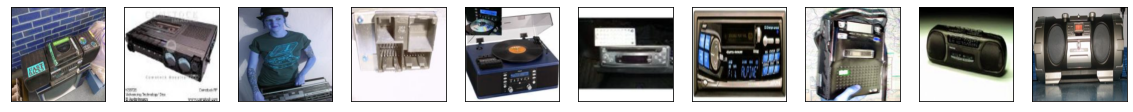

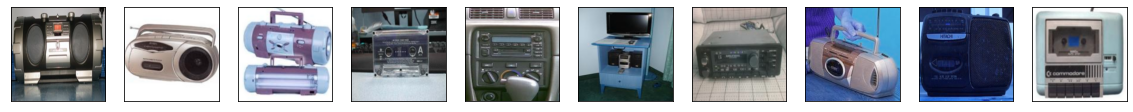

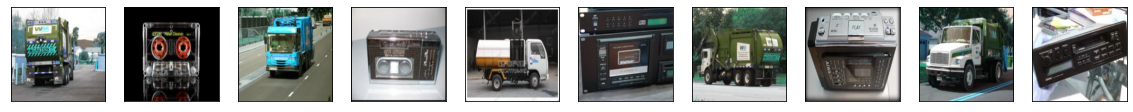

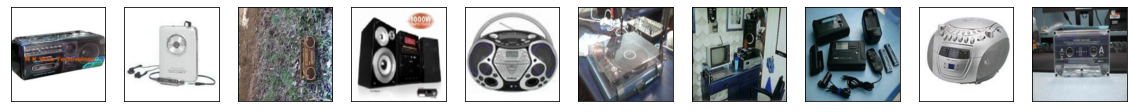

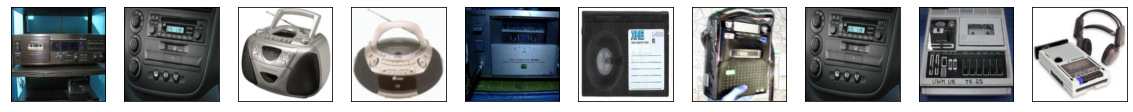

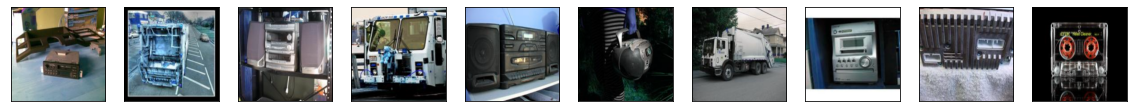

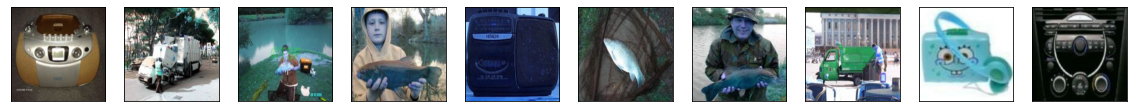

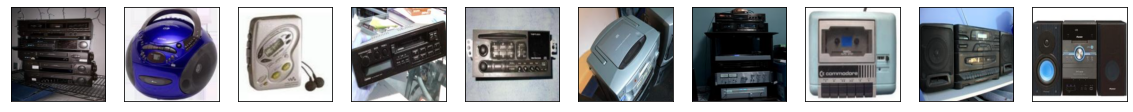

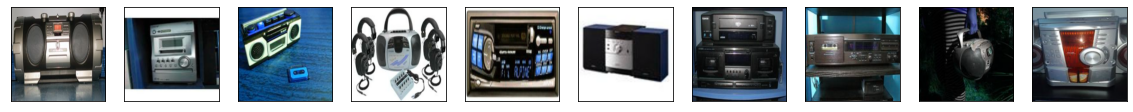

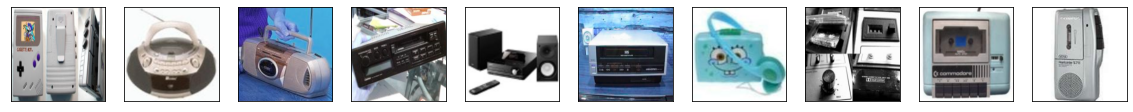

In [16]:
for cluster_idx in range(NUM_CLUSTERS):
    print(f"Class {cluster_idx + 1}")
    cluster_imgs = np.array(np.where(clustered_imgs == cluster_idx))

    plt.figure(figsize=(20, 4))

    for j in range(10):
        pos = random.randint(0, np.size(cluster_imgs))
        ax = plt.subplot(2, NUM_CLUSTERS, j + 1)
        original_img = original_imgs[pos]
        
        plt.imshow(original_img.permute(1, 2, 0))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)